In [82]:
import librosa
import numpy as np
import random
import rosbag
import struct
import tams_pr2_guzheng
from collections import Counter
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-v0_8')
from matplotlib.animation import FuncAnimation
from IPython import display

%load_ext autoreload
%autoreload 1
import sys
if '../utils' not in sys.path:
    sys.path.append('../utils')
import u
%aimport u

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
bag_name = "guzheng_150_fis4_random_ypos_2023-06-15-18-57-36_extracted_episodes.bag"

In [2]:
bag_name = "guzheng_150_fis4_random_ypos_dir-1.0_2023-06-15-19-18-40_extracted_episodes.bag"

In [106]:
note = "fis4"

In [107]:
bag = rosbag.Bag("../../../../bags/" + bag_name)
episodes_full_bag = [m for t, m, _ in bag.read_messages()]

# limit analysis to a single string
episodes_all = [e for e in episodes_full_bag if e.string == note]

# drop invalid samples
episodes_valid = [
    e
    for e in episodes_all
    if (
        len(e.detected_audio_onsets) == 0
        or len(e.detected_audio_onsets) > 0
        and e.start_execution < e.detected_audio_onsets[0].header.stamp
        and e.string in [u.note_to_string(o.note) for o in e.detected_audio_onsets]
    )
    and len(e.executed_path.poses) > 0
]
episodes = episodes_valid
episodes_with_onset = [e for e in episodes if len(e.detected_audio_onsets) > 0]
episodes_with_one_onset = [e for e in episodes if len(e.detected_audio_onsets) == 1]
episodes_with_no_onset = [e for e in episodes if len(e.detected_audio_onsets) == 0]

In [108]:
string_position = np.array([e.action_parameters.action_parameters[-1] for e in episodes_with_one_onset])
keypoint_pos_y = np.array([e.action_parameters.action_parameters[10] for e in episodes_with_onset])
loudness = np.array([e.detected_audio_onsets[0].loudness for e in episodes_with_onset])

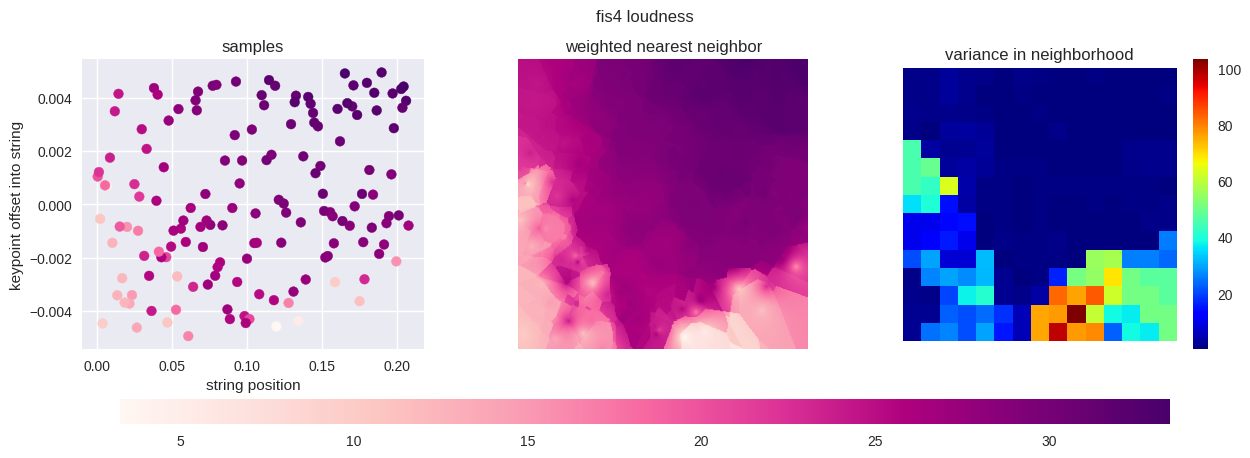

In [109]:
def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))


x = string_position
y = keypoint_pos_y
c = loudness

from scipy.spatial import cKDTree

grid_size = 300
# output grid
weighted_nearest_neighbor = np.zeros((grid_size, grid_size))
# coordinates
xi, yi = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
grid_points = np.column_stack((xi.ravel(), yi.ravel()))
tree = cKDTree(np.column_stack((normalize(x), normalize(y))))
distances, indices = tree.query(grid_points, k=3)
for i in range(grid_size):
    for j in range(grid_size):
        weights = 1.0 / distances[i * grid_size + j]  # Inverse of distances as weights
        weights /= np.sum(weights)  # Normalize weights
        weighted_nearest_neighbor[i, j] = np.dot(c[indices[i * grid_size + j]], weights)

grid_size = 15
# output grid
vari = np.zeros((grid_size, grid_size))
# coordinates
xi, yi = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
grid_points = np.column_stack((xi.ravel(), yi.ravel()))
tree = cKDTree(np.column_stack((normalize(x), normalize(y))))
distances, indices = tree.query(grid_points, k=5)
for i in range(grid_size):
    for j in range(grid_size):
        neighborhood = c[indices[i * grid_size + j]]
        vari[i, j] = np.var(neighborhood)

cmap = plt.get_cmap("RdPu")
# cmap=plt.get_cmap('brg')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"{note} loudness")
# Q.plot(x='string_position', y='keypoint_pos_y', kind='scatter', c='loudness', colormap='brg', ax=ax[0], colorbar=False)
ax[0].scatter(x, y, c=c, cmap=cmap)
ax[0].set_title("samples")
ax[0].set_xlabel("string position")
ax[0].set_ylabel("keypoint offset into string")

im = ax[1].imshow(weighted_nearest_neighbor, cmap=cmap, origin="lower")
ax[1].axis("off")
ax[1].set_title("weighted nearest neighbor")

imvar = ax[2].imshow(vari, cmap="jet", origin="lower")
ax[2].axis("off")
ax[2].set_title("variance in neighborhood")
fig.colorbar(imvar, ax=ax[2])

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
u.save_plot(f"string kp_ypos {note} {bag_name}")


In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm

from torch.utils.tensorboard import SummaryWriter

def torch_normalize(X):
    mean = X.mean(dim=0).detach().numpy()
    std = torch.std(X, dim=0).detach().numpy()
    return (X - mean)/std, (mean, std)

In [111]:
features = np.stack((string_position, keypoint_pos_y)).T

features_tensor, features_norm_params = torch_normalize(torch.FloatTensor(features))
loudness_tensor, loudness_norm_params = torch_normalize(torch.FloatTensor(loudness[:,np.newaxis]))

In [113]:
ds = [(features_tensor[i, :], loudness_tensor[i]) for i in range(len(loudness))]
dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size= features.shape[0])

In [114]:
def predict_grid():
    grid_size = 100
    # output grid
    nn_pred = np.zeros((grid_size, grid_size))
    # coordinates
    xi, yi = np.meshgrid(
        np.linspace(np.min(features[:,0]), np.max(features[:,0]), grid_size),
        np.linspace(np.min(features[:,1]), np.max(features[:,1]), grid_size)
        )
    grid_points = torch.FloatTensor(np.column_stack((xi.ravel(), yi.ravel())))
    grid_points = (grid_points-features_norm_params[0])/features_norm_params[1]
    return net.predict(torch.FloatTensor(grid_points)).reshape((grid_size, grid_size))


In [175]:
def plot_prediction_overview():
    predicted_loudness = net.predict(features_tensor)

    fig = plt.figure(figsize=(20, 5), dpi=100)
    sample_ax = plt.subplot(1, 4, 1)
    plt.suptitle(f"loudness prediction {note} {bag_name}")
    sample_plt = plt.scatter(x, y, c=loudness, cmap=cmap)
    vmin= np.min(loudness)
    vmax= np.max(loudness)
    plt.gca().set_title("samples")
    plt.gca().set_xlabel("string position")
    plt.gca().set_ylabel("keypoint offset into string")
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    cbar = plt.colorbar(sample_plt, location='left')
    # add label to colorbar
    cbar.ax.set_ylabel('loudness')

    plt.subplot(1, 4, 2)
    plt.imshow(weighted_nearest_neighbor, cmap=cmap, origin="lower", vmin=vmin, vmax=vmax)
    plt.axis("off")
    plt.title("weighted nearest neighbor")

    plt.subplot(1, 4, 3)
    plt.imshow(predict_grid(), origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off');
    plt.title(f"network prediction ({','.join([str(x) for x in net.layer_sizes])})")

    plt.subplot(1,4,4)

    error= np.abs(loudness - predicted_loudness)
    plt.title('sample error')
    plt.scatter(x,y, c=error, cmap='Reds')
    plt.colorbar()

    plt.tight_layout()
    return fig

# plot_prediction_overview();

In [202]:
# regress volume
class Net(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers= nn.ModuleList()
        previous_n= 2
        for n in layer_sizes:
            self.layers.append(nn.Linear(previous_n, n))
            previous_n = n
        self.layers.append(nn.Linear(previous_n, 1))
        self.layer_sizes = layer_sizes

    def forward(self, x):
        # x = self.fc1(x)
        for l in self.layers:
            x = F.relu(l(x))
        return x

    def predict(self, features_tensor):
        with torch.no_grad():
            return self(features_tensor).detach().numpy().ravel()*loudness_norm_params[1]+loudness_norm_params[0]


net = Net( [32, 16] )
criterion = nn.MSELoss()
# opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
try: writer.close()
except: pass
writer = SummaryWriter()
epoch = 0

In [206]:
try:
    for epoch in tqdm(range(epoch, epoch+20000)):
        for i, data in enumerate(dl):
            inputs, labels = data
            opt.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            opt.step()
        if epoch % 5000 == 1:
            fig = plot_prediction_overview()
            writer.add_figure("prediction overview", fig, epoch)
            plt.close(fig)
    writer.flush()
except KeyboardInterrupt:
    pass

100%|██████████| 20000/20000 [00:23<00:00, 836.57it/s] 


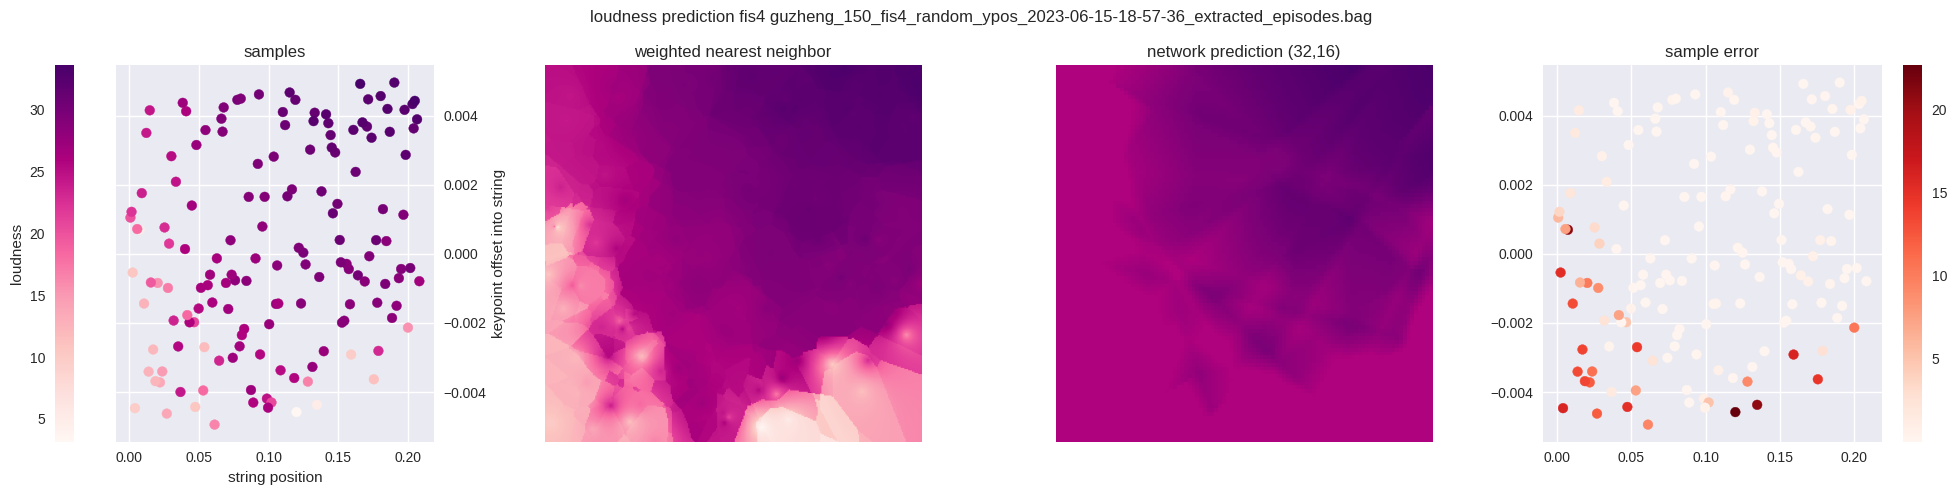

In [207]:
predicted_loudness = net.predict(features_tensor)
fig = plot_prediction_overview()
u.save_plot(fig._suptitle.get_text()+" nn("+",".join([str(s) for s in net.layer_sizes])+")");
# plt.close(fig)

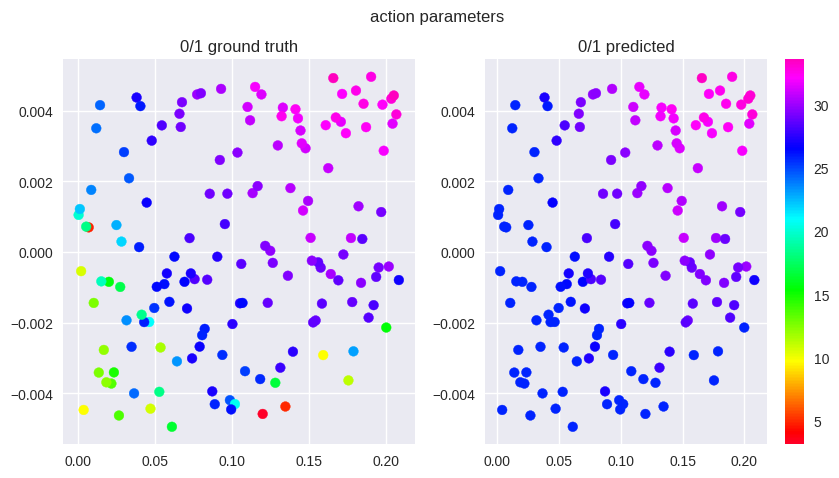

In [211]:
def plot_samples_by_parameters():
    cmap = plt.get_cmap("gist_rainbow")

    sidx = 1
    from itertools import combinations
    combs = list(combinations(range(features.shape[1]), 2))

    plt.figure(figsize=(10, 5 * len(combs)), dpi=100)
    plt.suptitle("action parameters")
    vmin= np.min(loudness)
    vmax= np.max(loudness)
    for i, j in combs:
        gt_ax = plt.subplot(len(combs), 2, sidx)
        sidx += 1
        plt.title(f"{i}/{j} ground truth")
        plt.scatter(features[:, i], features[:, j], cmap=cmap, c=loudness, vmin= vmin, vmax= vmax)
        plt.subplot(len(combs), 2, sidx)
        sidx += 1
        plt.title(f"{i}/{j} predicted")
        plt.scatter(features[:, i], features[:, j], cmap=cmap, c=predicted_loudness, vmin= vmin, vmax= vmax)
        plt.colorbar()

plot_samples_by_parameters()